In [70]:
print("all ok")

all ok


In [71]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\Dell\Documents\automates-research-report-generation


In [72]:
from research_and_analyst.utils.model_loader import ModelLoader

In [73]:
model_loader = ModelLoader()

{"timestamp": "2025-10-13T21:07:25.758252Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-13T21:07:25.766574Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-13T21:07:25.770734Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-13T21:07:25.776837Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-13T21:07:25.780463Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-13T21:07:25.783089Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-13T21:07:25.850526Z", "level": "info", "event": "YAML config loaded"}


In [74]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-13T21:07:26.541618Z", "level": "info", "event": "Loading LLM"}


In [75]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [76]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [77]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [78]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [79]:
Analyst(
    name="Josie Ndumu",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='Josie Ndumu', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [80]:
analyst = Analyst(
    name="Josie Ndumu",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [81]:
analyst.name

'Josie Ndumu'

In [82]:
analyst.role

'genai eng'

In [83]:
analyst.affiliation

'AI Research LAB'

In [84]:
print(analyst.persona)

Name: Josie Ndumu
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [85]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [86]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [87]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [88]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [89]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [90]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [91]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [92]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Analyst', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends and the impact of public health policies on population health outcomes. Her primary concern is understanding how different health interventions can reduce disease burden and improve quality of life across diverse populations. She is motivated by the need to provide evidence-based recommendations to policymakers to enhance public health infrastructure and response strategies.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard T.H. Chan School of Public Health', description='Dr. Raj Patel specializes in the intersection of healthcare and technology, particularly how digital health innovations can transform patient care and health system efficiency. His focus is on evaluating the effectiveness of telemedicine, electronic health records, and AI-driven diagnostics in improvin

In [93]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [94]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [95]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [96]:
from IPython.display import Image, display

## First Workflow

In [97]:
builder = StateGraph(GenerateAnalystsState)

In [98]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [99]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [100]:
memory = MemorySaver()

In [101]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

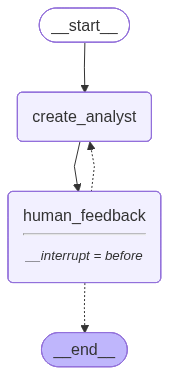

In [102]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [103]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [104]:
max_analysts = 4

In [105]:
thread =  {"configurable":{"thread_id":1}}

In [106]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based modeling. Her research is driven by the need to understand the scalability and flexibility of AI frameworks in dynamic environments.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: Software Development Lead
Description: Raj is a software development lead who is interested in the practical implementation of AI frameworks like Langgraph. His primary concern is how adopting Langgraph can streamline development processes and improve the efficiency of software projects.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: FutureTech Consulting
Role: Business Strategist
Description: Sophia analyzes the strategic benefits of adopting new technologies in business. She i

In [107]:
state = graph.get_state(thread)

In [108]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based modeling. Her research is driven by the need to understand the scalability and flexibility of AI frameworks in dynamic environments.'), Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Tech Innovators Inc.', description='Raj is a software development lead who is interested in the practical implementation of AI frameworks like Langgraph. His primary concern is how adopting Langgraph can streamline development processes and improve the efficiency of software projects.'), Analyst(name='Sophia Martinez', role='Business Strategist', affiliation='FutureTech Consulting', description='Sophia analyzes t

In [109]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based modeling. Her research is driven by the need to understand the scalability and flexibility of AI frameworks in dynamic environments.'),
  Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Tech Innovators Inc.', description='Raj is a software development lead who is interested in the practical implementation of AI frameworks like Langgraph. His primary concern is how adopting Langgraph can streamline development processes and improve the efficiency of software projects.'),
  Analyst(name='Sophia Martinez', role='Business Strategist', affiliation='FutureTech Consulting', description='Sophia analyzes the strategic be

In [110]:
state.next

('human_feedback',)

In [111]:
# memory.storage

In [112]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0a878c-f84f-6399-bfff-de47cce7d0dc': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-13T21:08:47.962408+00:00\xa2id\xd9$1f0a878c-f84f-6399-bfff-de47cce7d0dc\xb0channel_versions\x81\xa9__start__\xd9500000000000000000000000000000001.0.040928068116125926\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0a878c-f85a-64d8-8000-0a219ca6a859': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-13T21:08:47.966946+00:00\xa2id\xd9$1f0a878c-f85a-64d8-8000-0a219ca6a859\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.6476508070473904\xa5topic\xd9300000000000000000000000000000002.0.6476508070473904\xacmax_analysts\xd9300000000000000000000000000000002.0.6476508070473904\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.6476508070473904\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\

In [113]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [114]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a878d-3270-6ca0-8001-2b096abccc71'}}

In [115]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a878d-65ed-6ed7-8002-ce2dcac11585'}}

In [116]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based modeling. Her research is driven by the need to understand the scalability and flexibility of AI frameworks in dynamic environments.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: Software Development Lead
Description: Raj is a software development lead who is interested in the practical implementation of AI frameworks like Langgraph. His primary concern is how adopting Langgraph can streamline development processes and improve the efficiency of software projects.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: FutureTech Consulting
Role: Business Strategist
Description: Sophia analyzes the strategic benefits of adopting new technologies in business. She i

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in large-scale operations, focusing on its ability to improve data processing, enhance AI capabilities, and support complex decision-making processes in multinational corporations.
--------------------------------

In [117]:
state = graph.get_state(thread)

In [118]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of L

In [119]:
state.next

('human_feedback',)

In [120]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'),
  Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in larg

In [121]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [122]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [123]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [124]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a878d-eb7a-6b4a-8006-73f22fdc04af'}}

In [125]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [126]:
analysts = final_state.values.get('analysts')

In [127]:
analysts

[Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'),
 Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in large-scale operations, focusing on its ability to improve data processing, enhance AI capabilities, and support complex decision-making processes in multinational corporations.'),
 Analyst(name='Aisha Patel', role='AI Framework

In [128]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in large-scale operations, focusing on its ability to improve data processing, enhance AI capabilities, and support complex decision-making processes in multinational corporations.
--------------------------------

In [129]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


## Second Workflow

In [130]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [131]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [132]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [133]:
tavily_search.invoke("langgraph")

[{'title': 'What is LangGraph? - Analytics Vidhya',
  'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
  'content': 'To sum up, LangGraph is a major advancement in the development of AI agents. It enables developers to push the limits of what’s possible with AI agents by eliminating the shortcomings of earlier systems and offering a flexible, graph-based framework for agent construction and execution. LangGraph is positioned to influence the direction of artificial intelligence significantly in the future. [...] LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents.\n   It views agent Objective Points about LangGraph and workflows as cyclic graph topologies, allowing for more variable and nuanced agent behaviors than linear execution models. [...] Frameworks such as LangGraph are becoming increasingly important as AI develops. LangGraph is m

In [134]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [135]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [136]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [137]:
print(analyst.persona)

Name: Liam O'Connor
Role: Business Strategy Consultant
Affiliation: FutureTech Consulting
Description: Liam advises businesses on strategic technology adoption, with a focus on the competitive advantages offered by Langgraph. He analyzes market trends and provides insights on how companies can use Langgraph to gain a competitive edge, improve customer engagement, and drive innovation in their respective industries.



In [138]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Liam O\'Connor\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Liam advises businesses on strategic technology adoption, with a focus on the competitive advantages offered by Langgraph. He analyzes market trends and provides insights on how companies can use Langgraph to gain a competitive edge, improve customer engagement, and drive innovation in their respective industries.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the 

In [139]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you

In [140]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [141]:
analyst

Analyst(name="Liam O'Connor", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic technology adoption, with a focus on the competitive advantages offered by Langgraph. He analyzes market trends and provides insights on how companies can use Langgraph to gain a competitive edge, improve customer engagement, and drive innovation in their respective industries.')

In [142]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [143]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [144]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name="Liam O'Connor", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic technology adoption, with a focus on the competitive advantages offered by Langgraph. He analyzes market trends and provides insights on how companies can use Langgraph to gain a competitive edge, improve customer engagement, and drive innovation in their respective industries.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [145]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [146]:
result

{'messages': [AIMessage(content="Hello, I'm Alex Thompson, a technology journalist with a keen interest in emerging tech trends. I'm excited to learn more about how businesses can leverage Langgraph for strategic advantages. \n\nLiam, could you start by explaining what Langgraph is and why it's becoming a significant tool for businesses looking to gain a competitive edge?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 243, 'total_tokens': 306, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CQK7poYWX4HllO6oMfV39KtGQlF9x', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d3a0056c-39a2-4b88-b700-d45812ab1ec4-0', usage_metadata={'input_tokens': 24

In [147]:
print(result["messages"][0].content)

Hello, I'm Alex Thompson, a technology journalist with a keen interest in emerging tech trends. I'm excited to learn more about how businesses can leverage Langgraph for strategic advantages. 

Liam, could you start by explaining what Langgraph is and why it's becoming a significant tool for businesses looking to gain a competitive edge?


In [148]:
from langchain_core.messages import get_buffer_string

In [149]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [150]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [151]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [152]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [153]:
print(result["context"][0])

<Document href="https://medium.com/@kajal.verma/langgraph-building-smarter-ai-agents-with-graph-based-workflows-b520eadfc582"/>
If you’re looking to create advanced AI systems that can evolve and scale with your business, LangGraph is the framework you need. From visualizing AI workflows to orchestrating AI agents and automating tasks, LangGraph gives you the tools to build the next generation of intelligent applications.

AI

Langgraph

Landgraph Ai

Ai Agent

## Written by Digital Transformation

0 followers

·1 following [...] Whether you’re building a chatbot, data analytics pipeline, or a machine learning model, workflow automation with AI helps ensure processes are completed faster and with fewer errors. By using graph logic to model the tasks, LangGraph allows for real-time adjustments and re-routing in case something goes wrong.

## Get Digital Transformation’s stories in your inbox

Join Medium for free to get updates from this writer. [...] Sitemap

Open in app

Sign in

Sign

In [154]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [155]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [156]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework benefits for business innovation and digital transformation'


In [157]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [158]:
search_docs

[]

In [159]:
result

{'context': ['']}

In [160]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [161]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [162]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [163]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [164]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [165]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [166]:
interview_builder = StateGraph(InterviewState)

In [167]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [168]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [169]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


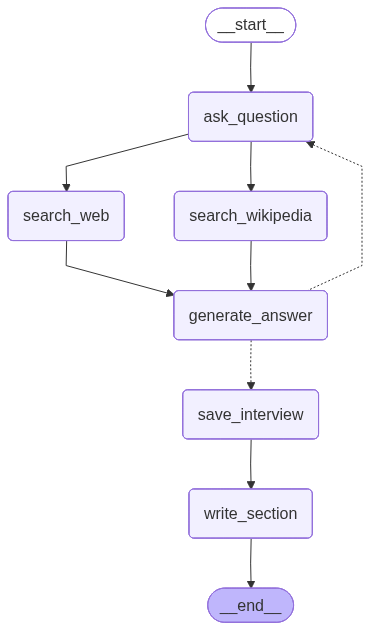

In [170]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [171]:
analyst

Analyst(name="Liam O'Connor", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic technology adoption, with a focus on the competitive advantages offered by Langgraph. He analyzes market trends and provides insights on how companies can use Langgraph to gain a competitive edge, improve customer engagement, and drive innovation in their respective industries.')

In [172]:
analyst.persona

"Name: Liam O'Connor\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Liam advises businesses on strategic technology adoption, with a focus on the competitive advantages offered by Langgraph. He analyzes market trends and provides insights on how companies can use Langgraph to gain a competitive edge, improve customer engagement, and drive innovation in their respective industries.\n"

In [173]:
thread = {"configurable": {"thread_id": "1"}}

In [174]:
from IPython.display import Markdown

In [175]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [176]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph technology strategic advantages for businesses'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph case study competitive advantage business example'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [177]:
Markdown(interview['sections'][0])

## Harnessing LangGraph for Strategic Technological Advantage

### Summary

In the rapidly evolving landscape of artificial intelligence, businesses are increasingly seeking frameworks that not only enhance operational efficiency but also provide a strategic edge. LangGraph emerges as a pivotal technology in this context, offering a robust platform for orchestrating complex, multi-agent workflows. This report delves into the strategic advantages of adopting LangGraph, highlighting its potential to transform business operations and drive innovation.

LangGraph is a framework that enables businesses to automate and augment complex workflows, thereby enhancing decision-making speed and responsiveness. This capability is crucial for companies aiming to gain a competitive edge in customer engagement, data analysis, and innovation capacity. By leveraging LangGraph, businesses can ensure that their AI initiatives are scalable and maintainable, transforming them into long-term strategic assets rather than mere experimental projects [1].

One of the most compelling aspects of LangGraph is its ability to facilitate practical gains such as time and cost savings while reducing errors. The framework allows precise control over agent interactions, enabling parallel processing and decision-making pauses within workflows. This structured approach not only enhances efficiency but also ensures that AI systems are aligned with strategic business objectives [1].

LangGraph's impact is particularly pronounced in the retail sector, where it enables businesses to personalize customer interactions and streamline operations. By moving beyond static models to adaptive systems, LangGraph allows retail leaders to bridge the gap between automation and true personalization. This strategic shift is exemplified by companies like Uber and AppFolio, which utilize LangGraph for large-scale code migrations and property management tasks, respectively. These use cases demonstrate LangGraph's ability to manage complex workflows with multiple moving parts, ensuring reliability and scalability [2].

Moreover, LangGraph's advanced features, such as built-in state management and error handling, provide significant advantages over traditional frameworks like LangChain. These capabilities allow for automatic persistence, checkpointing, and rollback, making LangGraph a preferred choice for enterprises seeking to develop sophisticated, production-grade AI systems [3].

In conclusion, LangGraph represents a strategic choice for businesses aiming to harness the full potential of AI. Its ability to manage multi-agent workflows, coupled with its scalability and error resilience, positions it as a transformative technology in the AI landscape. As businesses continue to navigate the complexities of AI adoption, LangGraph offers a pathway to achieving sustainable competitive advantages.

### Sources
[1] https://www.scalablepath.com/machine-learning/langgraph  
[2] https://interviewkickstart.com/blogs/articles/langgraph-for-retail-ai-agent  
[3] https://thirdeyedata.ai/a-comparative-study-between-langgraph-and-langchain-for-enterprise-ai-development/  

## third Workflow